<img align="center" src="../extra/logos/logos.png" width='1200px'>

# Limpieza Fasat Charlie multi-spectral (fasat_charlie_ms)

Utilizaremos el notebook `02_Limpieza.ipynb` y `03_Análisis_básico.ipynb` como base para el proceso a desarrollar. 

Exploraremos las imágenes disponibles y su extensión.

## 0. Cargar librerías y datos

In [1]:
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access

configure_s3_access(aws_unsigned=False, requester_pays=True)

In [2]:
dc = datacube.Datacube(app='limpieza-fc') 

In [3]:
query = {
    "product": "fasat_charlie_ms",
    #"y": (-34.00, -32.00), 
    #"x": (-71.85, -70.00),
    #"time": ("1990-01-01", "2024-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-5.8, 5.8),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

In [4]:
ds = dc.load(**query)
ds

<xarray.Dataset>
Dimensions:      (time: 28, y: 367153, x: 22958)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-10T14:57:24.141532 ... 2024-02...
  * y            (y) float64 6.443e+06 6.443e+06 ... 4.313e+06 4.313e+06
  * x            (x) float64 1.955e+05 1.955e+05 ... 3.287e+05 3.287e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Podemos observar que obtenemos 28 tiempos, y una gran cantidad de píxeles en el eje x e y.
Adicionalmente, se obtienen solo las bandas `blue`, `green`, `red`, y `nir`.

Por otra parte, `Fasat Charlie` no cuenta con un `Quality Assessment Band`, por lo que no podremos generar máscaras para excluir nubes u otros elementos, como en los tutoriales de `Landsat` y `Sentinel`.

***

Exploraremos con consultar un tiempo en particular obtener su extensión.

> **Advertencia: la ubicación de la imagen y sus píxeles son aproximados.**

In [5]:
ds.time.values

array(['2012-01-10T14:57:24.141532000', '2012-01-19T14:34:29.659347000',
       '2012-09-28T14:30:03.199220000', '2013-09-03T15:05:18.094184000',
       '2013-11-11T15:11:04.900882000', '2014-02-14T15:14:57.795774000',
       '2014-04-08T15:11:53.091384000', '2014-04-13T15:07:14.519126000',
       '2014-04-14T15:25:31.938308000', '2014-07-10T14:39:42.520595000',
       '2015-06-16T15:19:56.179884000', '2015-08-13T15:17:10.685039000',
       '2015-09-19T15:17:46.904092000', '2015-11-27T15:20:41.358357000',
       '2015-12-01T15:02:10.116180000', '2016-09-22T14:50:05.371593000',
       '2016-12-27T15:02:09.750587000', '2017-01-06T14:51:29.933490000',
       '2017-02-11T14:36:55.012424000', '2017-11-29T14:49:11.485676000',
       '2017-12-27T15:13:17.135876000', '2018-03-16T15:10:56.860959000',
       '2018-03-25T14:47:28.730174000', '2018-03-26T15:01:50.920659000',
       '2018-05-28T14:59:47.876234000', '2018-12-20T14:55:47.061574000',
       '2019-02-22T15:06:46.070323000', '2024-02-09

In [6]:
ds_ = dc.load(time = "2014-02-14", **query)
ds_

<xarray.Dataset>
Dimensions:      (time: 1, y: 3387, x: 2825)
Coordinates:
  * time         (time) datetime64[ns] 2014-02-14T15:14:57.795774
  * y            (y) float64 4.351e+06 4.351e+06 ... 4.331e+06 4.331e+06
  * x            (x) float64 2.095e+05 2.095e+05 ... 2.259e+05 2.259e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


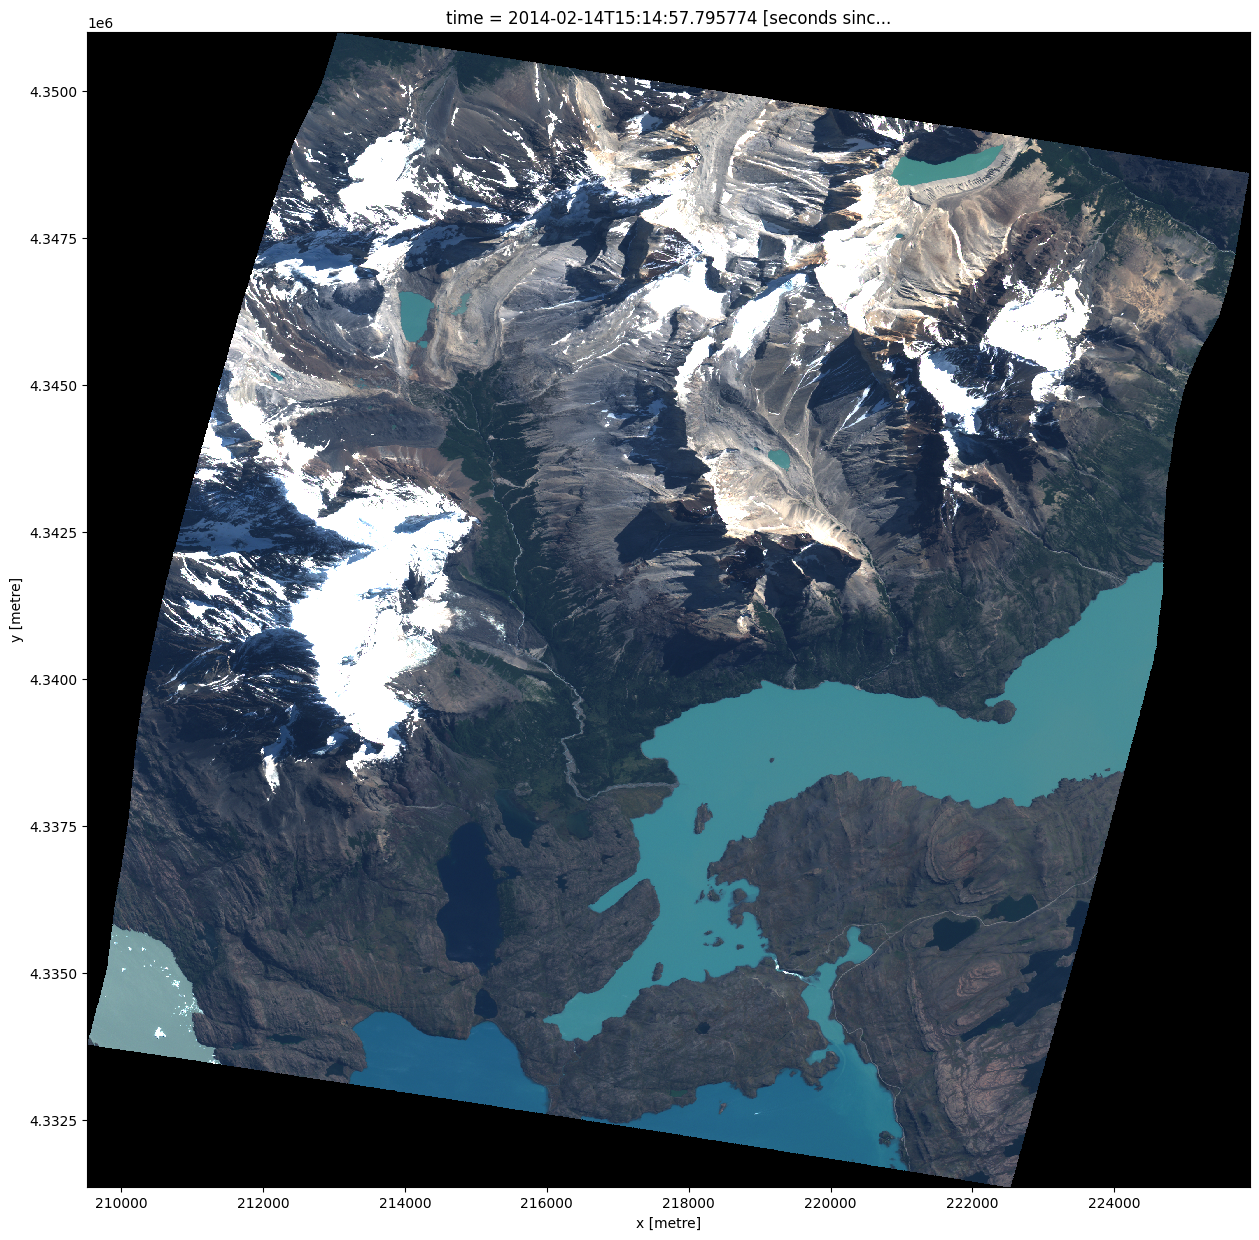

In [7]:
ds_[['red', 'green', 'blue']].squeeze().to_array().plot.imshow(vmin = 0, vmax = 3000, robust=True, figsize=(15,15))

Aquí podemos observar que el borde de la imágen está rellena con valores `0`, y se visualizan de color negro. Esto puede provocar que, al obtener estadísticas temporales, estos valores `0` sean tomados en cuenta en la estadística, obteniendo valores erróneos. Por este motivo, debemos ejecutar la siguiente celda para cambiar estos valores a `nan`.

In [8]:
dsf = ds_.where(ds_ != 0, np.nan)

# 1. Reescalar valores digitales a reflectancia
Es siempre necesario transformar los valores digitales a reflectancia antes de continuar con cualquier análisis. Para el producto Fasat Charlie Multi-Spectral, de momento, no contamos con información oficial para su obtención. Por este motivo, los códigos utilizados a continuación entregarán un valor de reflectividad aproximado.

> **Advertencia: los valores de reflectividad son aproximados, y los métodos de obtención no son oficiales.**

¿Cómo sabemos que tenemos valores digitales?, porque los valores de reflectividad debe ser un decimal entre 0 y 1.
Si graficamos una banda en particular, por ejemplo la banda roja, podemos observar el rango de valores que toma la imagen.

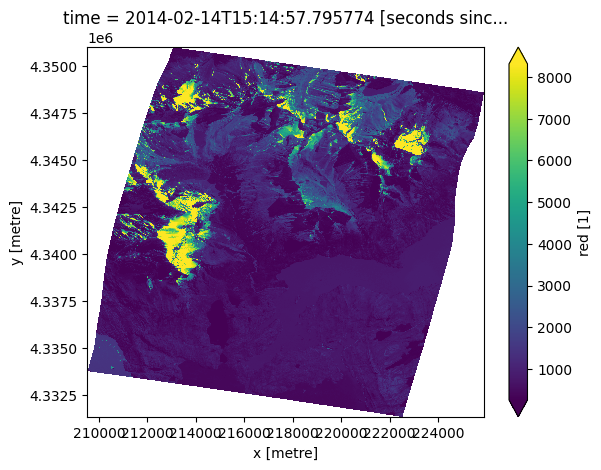

In [9]:
dsf.red.isel(time = 0).plot(robust = True)

Es posible observar valores entre 1000 y 7000, muy lejano de los decimales entre 0 y 1 que requerimos.

En este caso, vamos a utilizar el método de corrección `ND*0.0001`, donde `ND` es el valor que posee cada pixel en cada banda, esto lo hacemos con el siguiente código:

In [10]:
dsf.update(dsf * 0.0001)

<xarray.Dataset>
Dimensions:      (time: 1, y: 3387, x: 2825)
Coordinates:
  * time         (time) datetime64[ns] 2014-02-14T15:14:57.795774
  * y            (y) float64 4.351e+06 4.351e+06 ... 4.331e+06 4.331e+06
  * x            (x) float64 2.095e+05 2.095e+05 ... 2.259e+05 2.259e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Luego, debemos mantener solo los valores que sean válidos. Debido a que la reflectancia debiese entregar valores entre 0 y 1, debemos quedarnos solo con esos valores:

In [11]:
dsf.update(dsf.where((dsf >= 0) & (dsf <= 1)))

<xarray.Dataset>
Dimensions:      (time: 1, y: 3387, x: 2825)
Coordinates:
  * time         (time) datetime64[ns] 2014-02-14T15:14:57.795774
  * y            (y) float64 4.351e+06 4.351e+06 ... 4.331e+06 4.331e+06
  * x            (x) float64 2.095e+05 2.095e+05 ... 2.259e+05 2.259e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Volvemos a graficar, notando que ahora los valores en la escala de la derecha de la imagen han cambiado.

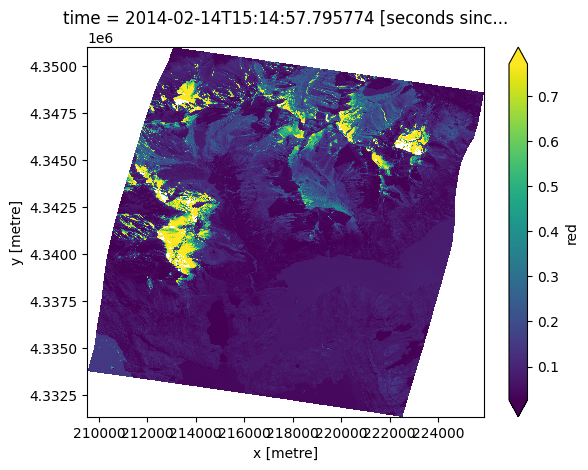

In [12]:
dsf.red.isel(time = 0).plot(robust = True)

***

# 2. Explorar imágenes Fasat Charlie

Durante esta sección exploraremos las imágenes enfocados en el sector de Petorca, Valparaíso y Glaciar Grey.
Para esto nos apoyaremos en un archivo vectorial de extensión geopackage llamado "dataton_zonas.gpkg"

In [13]:
import geopandas as gpd
poly = gpd.read_file("./dataton_zonas.gpkg")
poly

zona                                           geometry
0           petorca  MULTIPOLYGON (((-71.01176 -32.12425, -71.05574...
1        valparaíso  MULTIPOLYGON (((-71.38728 -32.81148, -71.55132...
2  torres del paine  MULTIPOLYGON (((-72.92871 -51.27458, -72.80814...

Exploraremos individualmente cada una de las zonas.

## 2.1. Petorca

Utilizando el primer polígono del vector `dataton_zonas` extraemos las coordenadas que nos ayudaran en la descarga de imágenes.

In [14]:
xmin, ymin, xmax, ymax = poly.iloc[[0]].total_bounds
ds1 = dc.load(x = (xmin, xmax), y = (ymin, ymax), **query)
ds1

<xarray.Dataset>
Dimensions:      (time: 3, y: 4206, x: 4055)
Coordinates:
  * time         (time) datetime64[ns] 2013-09-03T15:05:18.094184 ... 2017-12...
  * y            (y) float64 6.444e+06 6.444e+06 6.444e+06 ... 6.42e+06 6.42e+06
  * x            (x) float64 3.061e+05 3.061e+05 ... 3.296e+05 3.296e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Podemos observar que tenemos 3 imágenes, una de 2013, otra 2014, y una última de 2017.

Corregimos los valores ceros a `nan`, obtenemos la reflectividad.

In [15]:
ds1 = ds1.where(ds1 != 0, np.nan)
ds1.update(ds1 * 0.0001)
ds1.update(ds1.where((ds1 >= 0) & (ds1 <= 1)))

<xarray.Dataset>
Dimensions:      (time: 3, y: 4206, x: 4055)
Coordinates:
  * time         (time) datetime64[ns] 2013-09-03T15:05:18.094184 ... 2017-12...
  * y            (y) float64 6.444e+06 6.444e+06 6.444e+06 ... 6.42e+06 6.42e+06
  * x            (x) float64 3.061e+05 3.061e+05 ... 3.296e+05 3.296e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Finalmente, utilizamos la raíz cúbica de la reflectividad multiplicada por 0.6 como una forma de aumentar el contraste de una imagen al visualizarla. Exploraremos la imagen con índice `time = 0`.

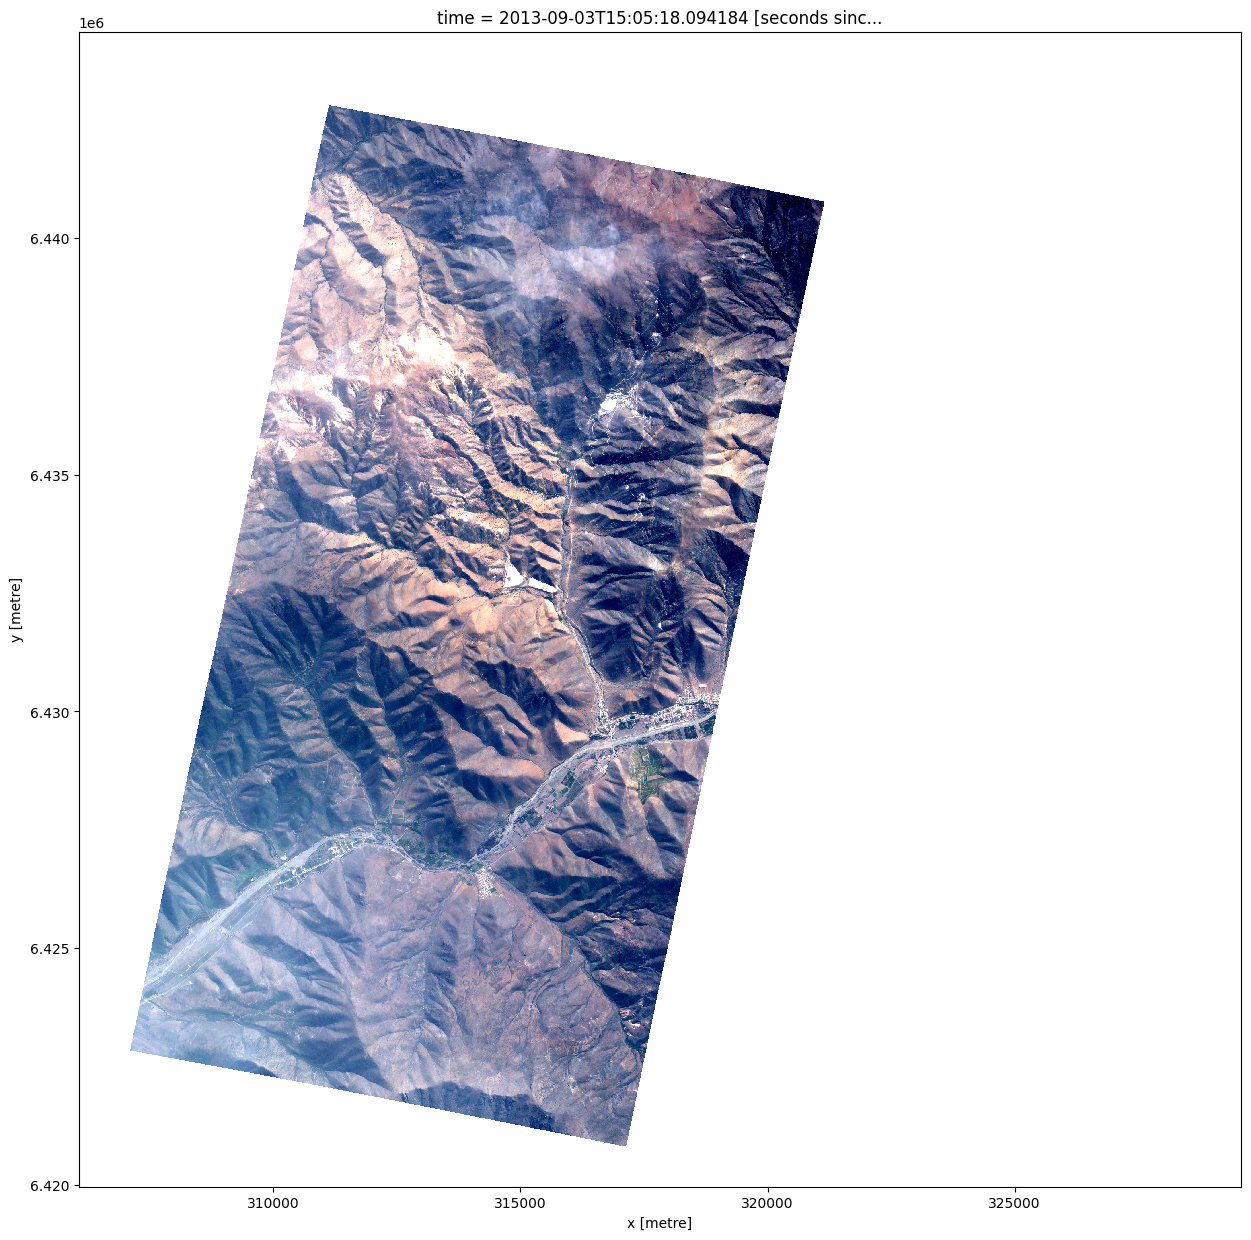

In [16]:
np.cbrt(0.6*ds1[['red', 'green', 'blue']].isel(time = 0)).to_array().plot.imshow(robust = True, figsize = (15,15), aspect = 1)

## 2.2. Valparaíso

Utilizando el segundo polígono del vector `dataton_zonas` hacemos el proceso que en la zona anterior.

In [17]:
xmin, ymin, xmax, ymax = poly.iloc[[1]].total_bounds
ds2 = dc.load(x = (xmin, xmax), y = (ymin, ymax), **query)
ds2

<xarray.Dataset>
Dimensions:      (time: 16, y: 12619, x: 6188)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-10T14:57:24.141532 ... 2024-02...
  * y            (y) float64 6.369e+06 6.369e+06 ... 6.296e+06 6.296e+06
  * x            (x) float64 2.422e+05 2.422e+05 ... 2.781e+05 2.781e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [18]:
ds2 = ds2.where(ds2 != 0, np.nan)
ds2.update(ds2 * 0.0001)
ds2.update(ds2.where((ds2 >= 0) & (ds2 <= 1)))

<xarray.Dataset>
Dimensions:      (time: 16, y: 12619, x: 6188)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-10T14:57:24.141532 ... 2024-02...
  * y            (y) float64 6.369e+06 6.369e+06 ... 6.296e+06 6.296e+06
  * x            (x) float64 2.422e+05 2.422e+05 ... 2.781e+05 2.781e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

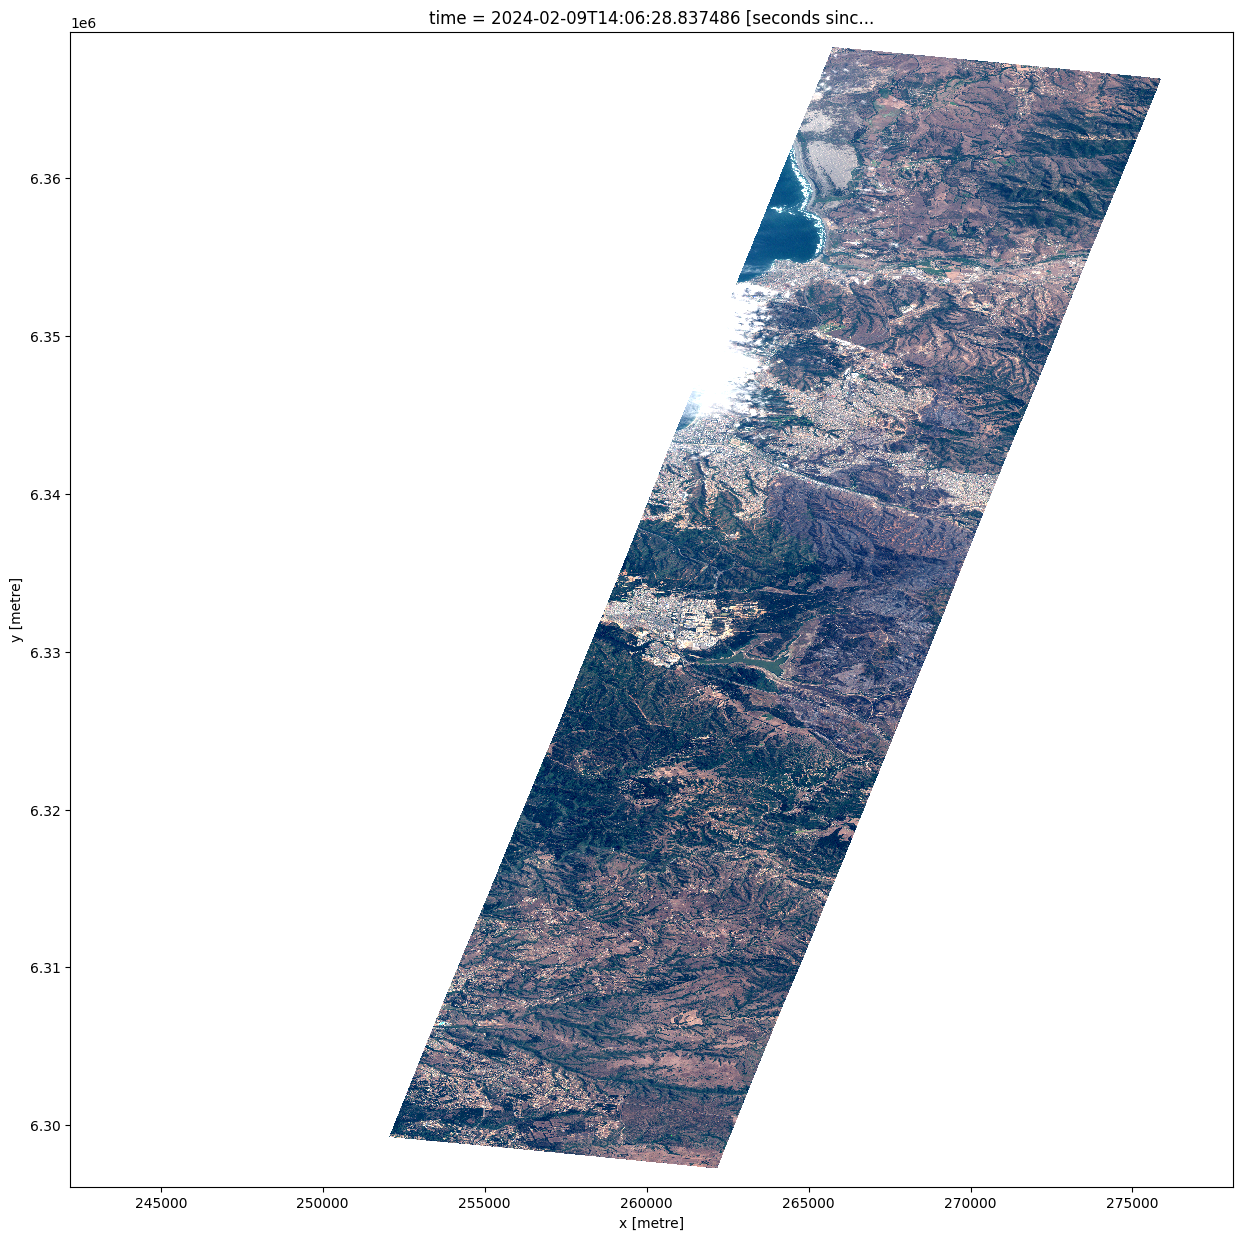

In [20]:
np.cbrt(0.6*ds2[['red', 'green', 'blue']].isel(time = 15)).to_array().plot.imshow(robust = True, aspect = 1, figsize = (15,15))

Y ahora en falso color `nir` `red` `green`.

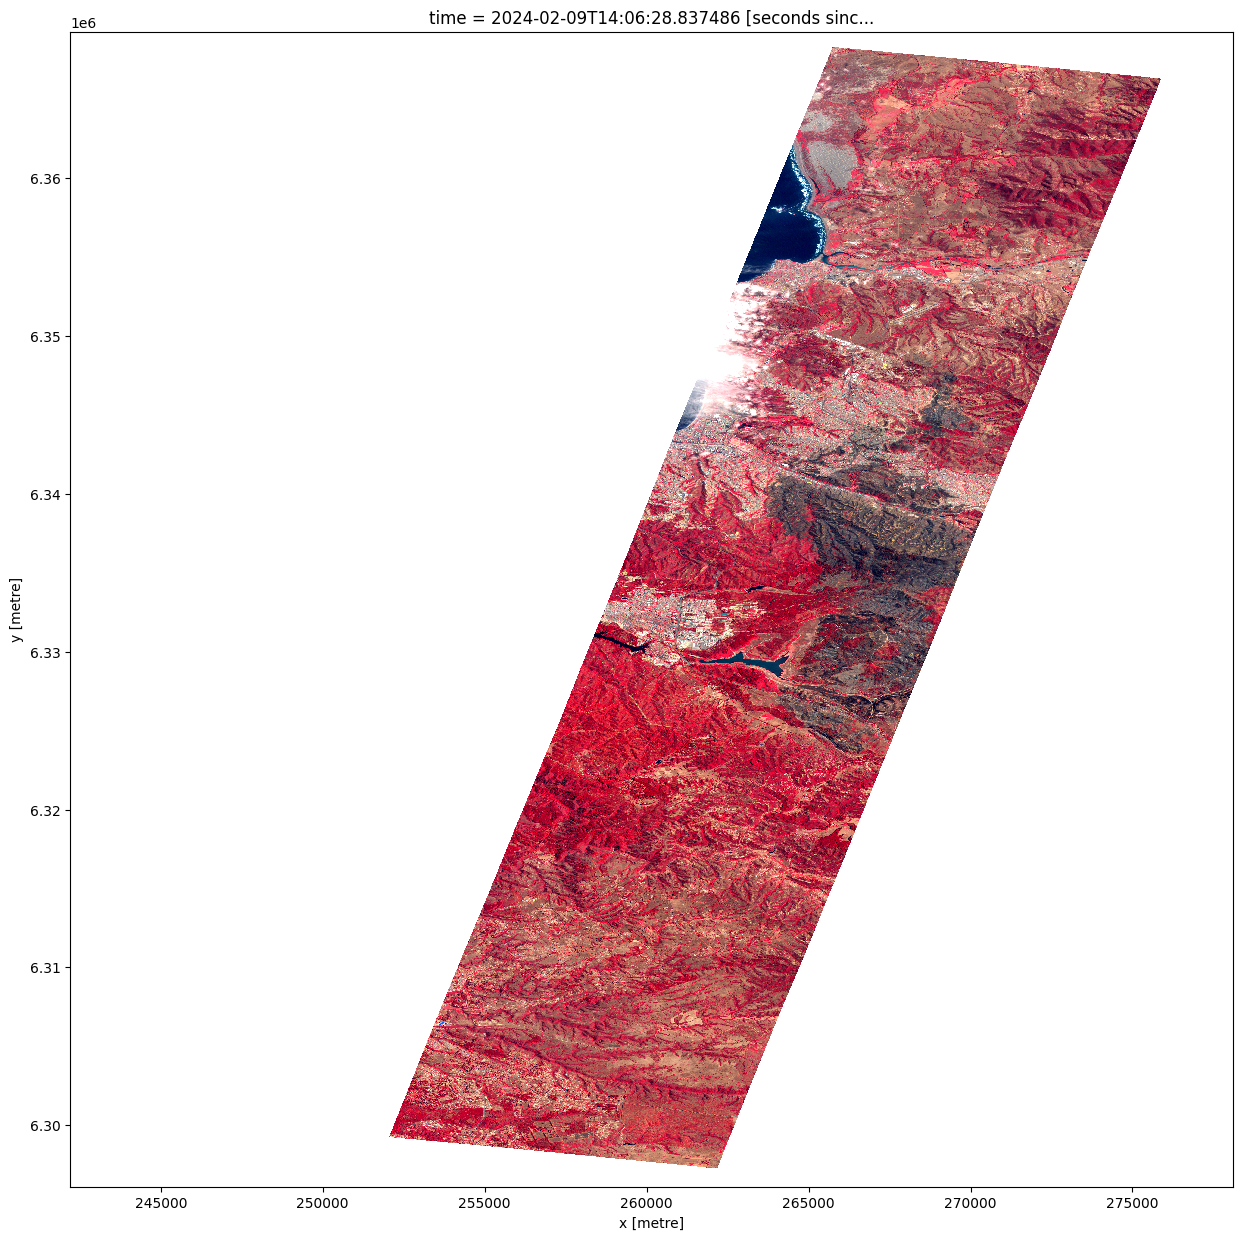

In [27]:
np.cbrt(0.6*ds2[['nir', 'red', 'green']].isel(time = 15)).to_array().plot.imshow(robust = True, aspect = 1, figsize = (15,15))

## 3. Glaciar Grey

Utilizando el tercer polígono del vector `dataton_zonas` hacemos el proceso que en la zona anterior.

In [21]:
xmin, ymin, xmax, ymax = poly.iloc[[2]].total_bounds
ds3 = dc.load(x = (xmin, xmax), y = (ymin, ymax), **query)
ds3

<xarray.Dataset>
Dimensions:      (time: 9, y: 8706, x: 7089)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-19T14:34:29.659347 ... 2018-05...
  * y            (y) float64 4.361e+06 4.361e+06 ... 4.311e+06 4.311e+06
  * x            (x) float64 1.933e+05 1.933e+05 ... 2.344e+05 2.344e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [22]:
ds3 = ds3.where(ds3 != 0, np.nan)
ds3.update(ds3 * 0.0001)
ds3.update(ds3.where((ds3 >= 0) & (ds3 <= 1)))

<xarray.Dataset>
Dimensions:      (time: 9, y: 8706, x: 7089)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-19T14:34:29.659347 ... 2018-05...
  * y            (y) float64 4.361e+06 4.361e+06 ... 4.311e+06 4.311e+06
  * x            (x) float64 1.933e+05 1.933e+05 ... 2.344e+05 2.344e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

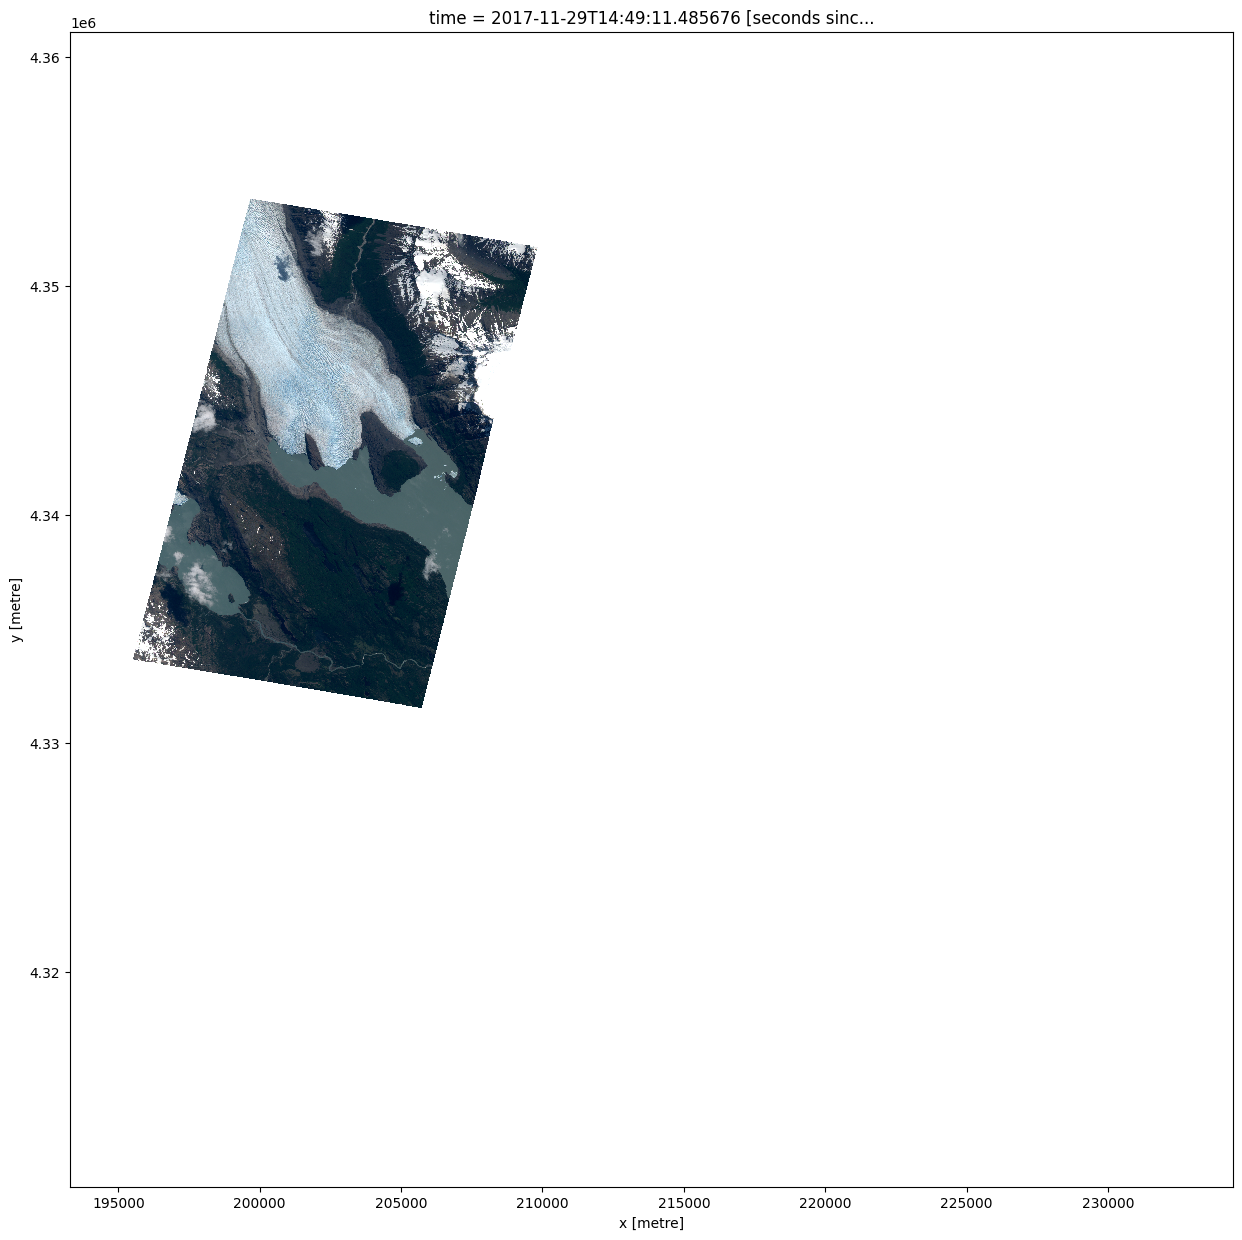

In [26]:
np.cbrt(0.6*ds3[['red', 'green', 'blue']].isel(time = 6)).to_array().plot.imshow(robust = True, figsize = (15,15), aspect = 1)

***

Finalmente, cerramos el cluster que hemos utilizado.

In [ ]:
client.close()

cluster.close()